# Gausian States and Gates

## Starting from Harmonic Oscillators

For this introduction, we will first consider a harmonic oscillator. The physical meaning of this choice is that photons are eigenstates of a harmonic oscillator system. The derivation is fairly simple and straightforward, therefore we will skip over it here. For simplicity, the notebook will have $\hbar = 1$.

For harmonic oscillators, we have the creation and annihilation operators, $\hat{a}$ and $\hat{a}^\dagger$. Physically, this is equivalent to adding and subtracting a photon. 

For example, if we have an n photon state $|n\rangle$, then applying the annihilation operator gives me the state $\hat{a} |n\rangle = \sqrt(n) |n-1\rangle$, with an extra normalization constant. From here, we can also derive the commutation relation $[\hat{a},\hat{a}^\dagger] = 1$. 

So far, this is all for single mode, which is usually fine but for a Imagine the modes as the frequency of the light that can exist in the environment (more accurately called a "cavity"). For multimode, the commutation relation is similar, but with a caveat that the operators need to be operating on the same mode of states, i.e. $[\hat{a}_i, \hat{a}_j] = \delta_{ij}$.

Next, we define position and momentum quadratures.
$$\hat{x} = \frac{1}{\sqrt{2}} (\hat{a} + \hat{a}^\dagger ) $$
$$\hat{p} = \frac{1}{i\sqrt{2}} (\hat{a} - \hat{a}^\dagger ) $$
In the physical sense, this describes the electric field's position and momentum, which I would like to convince you that it is the case if I had more time to make this notebook. It is also common to see that the operators have a factor of $1/2$ instead of $1/\sqrt{2}$, which is what I like since it makes certain operations nice. End of the day, it doesn't change much since it's just a factor on both axes.

We can also collect the $2n$ operators of $n$ modes into a $2n \times 1$ vector $\hat{r}$. The commutation relation can then be written as
$$ [\hat{r}_k, \hat{r}_l] = i \Omega_{kl} $$
where $\Omega_{kl}$ is generic element of the $2n \times 2n$ matrix. $\Omega$ is given as
$$
\Omega = \bigoplus_{k=1}^{2n} \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix} = \mathbb{I}_n \otimes \begin{pmatrix} 0 & 1 \\ -1 & 0 \end{pmatrix},
$$
where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

Next, we can define a covariance matrix $\sigma$ for an n-mode system.
$$ \sigma_{kl} = \frac{1}{2}\langle \{ \hat{r}_k, \hat{r}_l \} \rangle - \langle \hat{r}_k \rangle \langle \hat{r}_l \rangle $$
where $\{ \hat{r}_k, \hat{r}_l \} = \hat{r}_k\hat{r}_l + \hat{r}_l\hat{r}_k$ and $\langle \cdots \rangle$ means it's the average of something. For the sake of simplicity, we stick to single mode, and thus for a vacuum state, our covariance matrix for a vacuum state is just 
$$ \sigma = \begin{pmatrix} 0.5 & 0 \\ 0 & 0.5 \end{pmatrix} $$

In [1]:
import numpy as np
covMatrix = np.array([[0.5, 0], [0, 0.5]])
mean = np.zeros(2) # This would be our r-bar for the vacuum state

So our diagonal elements are just the expectation values for the x and p quadratures.

Now we introduce the Wigner function. Wigner function is a quasiprobability distribution, in the sense that it can display negative probabilities. There can't be a real probability distribution for a quantum state since it insinuates that knowing the exact value of a quadrature can then give a definitive answer on the likelihood of the other quadrature's value (think Heisenberg's identity), hence why we use a quasiproability distribution. In general, the Wigner function is defined as
$$ W(x,p) = \frac{1}{2^n} \int_{\mathbb{R}^n} \langle x + \frac{1}{2}q | \rho | x - \frac{1}{2}q \rangle e^{ip\cdot q} dq$$

Fortunately for us, all the states we look at today are Gaussian states, thus the Wigner function is easier to compute.
$$ W(r) = \frac{1}{(2\pi)^n \sqrt{\text{det}(\sigma)}}e^{-\frac{1}{2}(r-\bar{r})^T \sigma^{-1} (r - \bar{r})} $$
The reason why we use covariance matrix instead of density matrix, which is used alongside characteristic functions to define the Wigner function, is because of scalability. Density matrix is very information rich but it does not scale well with large number of photons - it's simply too large of a matrix to compute. For special cases like Gaussian matrix, it's much lighter to use covariance matrix instead.

In [2]:
def GaussianDistribution(diff, det, inv_cov):
    
    # Calculate the exponent for all points at once
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

### Gaussian states

We can first start with the vacuum state. Here, we've first defined the range of the quadratures, then looped over all the values to find the Wigner function numerically.

In [3]:
x_vals = np.linspace(-5, 5, 100)  # X quadrature range
p_vals = np.linspace(-5, 5, 100)  # P quadrature range

# Create a grid of (x, p) values
X, P = np.meshgrid(x_vals, p_vals)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)  # shape (10000,2)


def WignerCalc(diff, det, inv_cov):
    return GaussianDistribution(diff, det, inv_cov).reshape(X.shape)

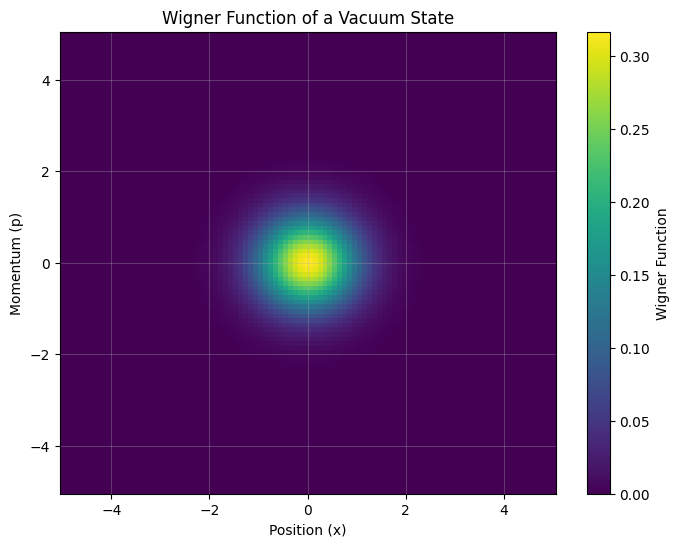

In [4]:
import matplotlib.pyplot as plt


diff = grid_points - mean
invCovM =  np.linalg.inv(covMatrix)
detCovM =  np.linalg.det(covMatrix)
W = WignerCalc(diff, detCovM, invCovM)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, P, W, shading='auto', cmap='viridis')
plt.colorbar(label='Wigner Function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Wigner Function of a Vacuum State')
plt.grid(alpha=0.3)
plt.show()

We can also introduce some fairly standard operations that one would do in a lab. In general, we can always describe the transformations as a matrix multiplication with our vector $r$ and the covariance matrix $\sigma$ as
$$\sigma \rightarrow F\sigma F^T$$
$$\bar{r} \rightarrow F\bar{r} + d $$
where F and d are the matrix and vector associated with a certain operation.

In [5]:
def ApplyTransformationAndDisplacement(cov, r, F, d):
    transformed_cov = F @ cov @ F.T
    transformed_r = F@r + d
    return transformed_cov, transformed_r

For displacement, the operator is expressed as $\hat{D}(\alpha) = e^{\alpha \hat{a}^\dagger - \alpha*\hat{a}}$, and its associated matrix and vector is
$$ F = \mathbb{I}_{2n}$$
$$ d = \sqrt{2} \begin{pmatrix} \text{Re}(\alpha_1) \\ \text{Im}(\alpha_1) \\ \vdots \\ \text{Re}(\alpha_n) \\ \text{Im}(\alpha_n) \end{pmatrix} $$

In [6]:
alpha = 2 + 2j
F_Displacement = np.eye(2)
d_Displacement = np.array([alpha.real, alpha.imag])

In [10]:
# Applying the operations
CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(covMatrix, mean, F_Displacement, d_Displacement)

diff_Co = grid_points - CoherentMean
invCovM_Co =  np.linalg.inv(CoherentCovMatrix)
detCovM_Co =  np.linalg.det(CoherentCovMatrix)

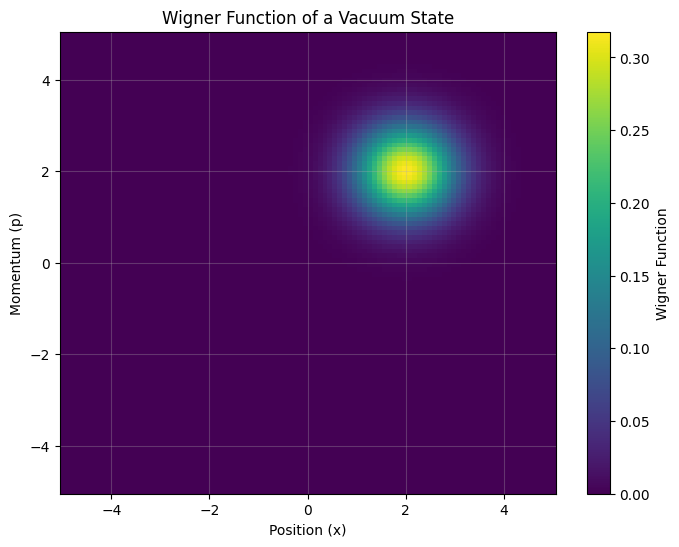

In [11]:
# Compute Wigner function over the grid
W = WignerCalc(diff_Co, detCovM_Co, invCovM_Co)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, P, W, shading='auto', cmap='viridis')
plt.colorbar(label='Wigner Function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Wigner Function of a Vacuum State')
plt.grid(alpha=0.3)
plt.show()

Here is a 3D plot if you're curious.

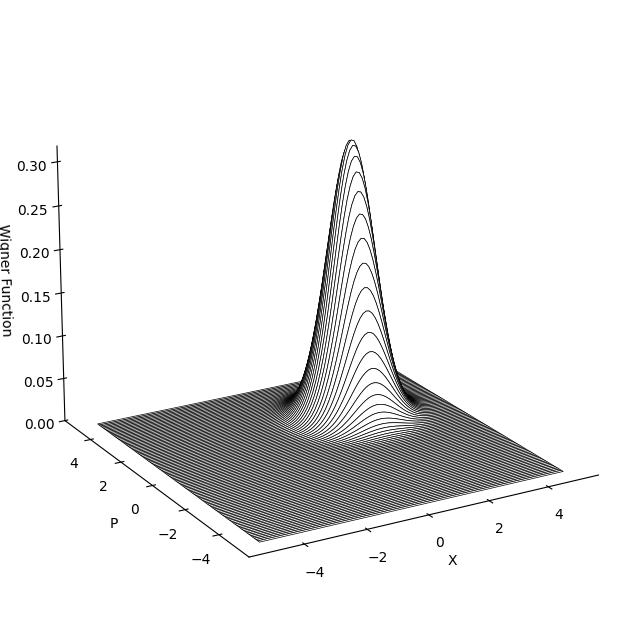

In [12]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the Wigner function
#ax.plot_surface(X, P, W, rstride=1, cstride=1, cmap='RdBu', edgecolor='k', lw=0.5, alpha=1.0)
ax.plot_surface(X, P, W, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)

# Customize the plot
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.grid(False)

# Set labels and limits
ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('Wigner Function')
ax.set_zlim(np.min(W), np.max(W))
ax.view_init(20, -120)  # Adjust the viewing angle

plt.show()

There are a myriad of other operations, such as phase shift, squeezing, squeezing, etc.

In [20]:
from ipywidgets import interact, FloatSlider
from matplotlib import cm


x_vals = np.linspace(-8, 8, 100)  # X quadrature range
p_vals = np.linspace(-8, 8, 100)  # P quadrature range
X, P = np.meshgrid(x_vals, p_vals)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)  # shape (10000,2)

In [21]:
def plot_wigner(r, theta, alpha_real, alpha_imag, angle_view):
    # Create displacement vector from α
    d_Displacement = np.array([alpha_real, alpha_imag])

    # Squeezing
    F_squeezing = np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    d_squeezing = np.zeros(2)  # No displacement for squeezing

    # Apply squeezing
    SqzcovMatrix,Sqzmean = ApplyTransformationAndDisplacement(covMatrix, mean, F_squeezing, d_squeezing)

    # Apply displacement
    CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(
        SqzcovMatrix, Sqzmean, F_Displacement, d_Displacement)
    
    
    invCovM =  np.linalg.inv(CoherentCovMatrix)
    detCovM =  np.linalg.det(CoherentCovMatrix)

    diff = grid_points - CoherentMean
    W = WignerCalc(diff, detCovM, invCovM)

    # 2D Plot
    # Create figure with adjusted dimensions and GridSpec
    fig = plt.figure(figsize=(18, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1.2])  # 1:1.2 width ratio
    
    # 2D Plot (left subplot) - Now square
    ax1 = fig.add_subplot(gs[0])
    pcm = ax1.pcolormesh(X, P, W, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax1, label='Wigner Function')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Momentum (p)')
    ax1.set_title(f'Wigner Function (α = {alpha_real:.1f} + {alpha_imag:.1f}i)')
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')  # This makes the plot square
    
    # 3D Plot (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, P, W, rstride=1, cstride=1, 
                          cmap=cm.Blues, edgecolor='k', 
                          linewidth=0.05, antialiased=True)
    
    # Customize 3D plot
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.set_xlabel('X')
    ax2.set_ylabel('P')
    #ax2.set_zlabel('Wigner Function')
    ax2.set_zlim(np.min(W), np.max(W))
    ax2.view_init(25, angle_view)  # Better viewing angle
    #fig.colorbar(surf, ax=ax2, label='Wigner Function')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(
    plot_wigner,
    r=FloatSlider(value=0, min=0, max=1, step=0.1, description='Sqz r:'),
    theta=FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1*np.pi, description='Sqz theta:'),
    alpha_real=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Re(α):'),
    alpha_imag=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Im(α):'),
    angle_view=FloatSlider(value=45, min=-180, max=180, step=0.1, description='View angle:')
)

interactive(children=(FloatSlider(value=0.0, description='Sqz r:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.plot_wigner(r, theta, alpha_real, alpha_imag, angle_view)>

In the plot above, we squeezed first before displacing. This is the usual approach in the lab since it's easier to control the state this way. You can think of squeezing as multiplying and displacing as addition. The difference between squeezing first then displacing versus displacing first is the same as plotting $y=2(x+9)$ and $y=2x+9$. Below is the reversed order of operation.

In [22]:
from ipywidgets import interact, FloatSlider, IntSlider
from matplotlib import cm

def plot_wigner2(alpha_real, alpha_imag, r, theta, angle_view):
    # Create displacement vector from α
    d_Displacement = np.array([alpha_real, alpha_imag])

    # Apply displacement
    CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(covMatrix, mean, F_Displacement, d_Displacement)
    
    
    # Squeezing
    F_squeezing = np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    d_squeezing = np.zeros(2)  # No displacement for squeezing

    # Apply squeezing
    SqzcovMatrix,Sqzmean = ApplyTransformationAndDisplacement(CoherentCovMatrix, CoherentMean, F_squeezing, d_squeezing)

    invCovM =  np.linalg.inv(SqzcovMatrix)
    detCovM =  np.linalg.det(SqzcovMatrix)

    diff = grid_points - Sqzmean
    W = WignerCalc(diff, detCovM, invCovM)
    
    # 2D Plot
    # Create figure with adjusted dimensions and GridSpec
    fig = plt.figure(figsize=(18, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1.2])  # 1:1.2 width ratio
    
    # 2D Plot (left subplot) - Now square
    ax1 = fig.add_subplot(gs[0])
    pcm = ax1.pcolormesh(X, P, W, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax1, label='Wigner Function')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Momentum (p)')
    ax1.set_title(f'Wigner Function (α = {alpha_real:.1f} + {alpha_imag:.1f}i)')
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')  # This makes the plot square
    
    # 3D Plot (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, P, W, rstride=1, cstride=1, 
                          cmap=cm.Blues, edgecolor='k', 
                          linewidth=0.05, antialiased=True)
    
    # Customize 3D plot
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.set_xlabel('X')
    ax2.set_ylabel('P')
    #ax2.set_zlabel('Wigner Function')
    ax2.set_zlim(np.min(W), np.max(W))
    ax2.view_init(25, angle_view)  # Better viewing angle
    #fig.colorbar(surf, ax=ax2, label='Wigner Function')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(
    plot_wigner2,
    alpha_real=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Re(α):'),
    alpha_imag=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Im(α):'),
    r=FloatSlider(value=0, min=0, max=1, step=0.1, description='Sqz r:'),
    theta=FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1*np.pi, description='Sqz theta:'),
    angle_view=FloatSlider(value=0, min=-180, max=180, step=1, description='View angle:')
)

interactive(children=(FloatSlider(value=0.0, description='Re(α):', max=4.0, min=-4.0), FloatSlider(value=0.0, …

<function __main__.plot_wigner2(alpha_real, alpha_imag, r, theta, angle_view)>

# Converting From Wigner Function to Density Matrix

It is particularly useful to know the density matrix of a state at times because of how much information we can extract from it. Here, we will demonstrate how to do so. We'll just use professor Jonas' equations from his paper. We essentially need this equation
$$ \rho_{mn} = 2 \pi \int \int^{+\infty}_{-\infty} W(x,p) W_{mn}(x,p) dx dp $$
where, for $m \geq n$,
$$ W_{mn}(x,p) = \frac{1}{\pi} e^{-x^2 - p^2} (-1)^n (x-ip)^{m-n} \sqrt{2^{m-n} \frac{n!}{m!}} L^{m-n}_{n} (2x + 2p) $$
Here, $L^{a}_n (x)$ is the generalized Laguerre polynomial. This would fill up only the lower diagonal half of the matrix. However, for $m < n$, we can simply write $W_{mn}(x,p) = W*_{nm} (x,p)$. So now we have filled up the entire matrix. 

For us to use the Laguerre polynomial, we'll have to call in SciPy. Moreover, the size of the matrix is the main bottleneck in calculating the density matrix, as discussed before. The Hilbert space is infinitely large, being able to contain any number of modes, thus the true density matrix is infinity by infinity. We will, however, define an arbitrary mode limit so that our laptops don't explode or physically decompose like a teenage highschool girl who has lost all her popularity.

In [28]:
import scipy as sp
from scipy import integrate

def Wmn(m, n, x, p):
    if m < n:
        return np.conj(Wmn(n, m, x, p))  # Use symmetry
    else:
        # Calculate the generalized Laguerre polynomial
        L = sp.special.genlaguerre(n, m-n)(2*x**2 + 2*p**2)
        return (1/np.pi) * np.exp(-x**2 - p**2) * (-1)**n * (x - 1j*p)**(m-n) * np.sqrt(2**(m-n) * sp.special.factorial(n) / sp.special.factorial(m)) * L

covMatrix_test = np.array([[0.5, 0], [0, 0.5]]) # Covariance matrix of a vacuum state
mean_test = np.zeros(2) # This would be our r-bar

invCovM =  np.linalg.inv(covMatrix_test)
detCovM =  np.linalg.det(covMatrix_test)
diff = grid_points - mean_test
W = WignerCalc(diff, detCovM, invCovM)

# Making our size limit
size_limit = 3  # Arbitrary size limit for the matrix
rho = np.zeros((size_limit, size_limit), dtype=complex)

In [35]:
# Here we use the SciPy integration to compute the density matrix
# It is very precise but also very slow

# Making our size limit
size_limit = 3  # Arbitrary size limit for the matrix

def GaussianDistribution_scalar(mean, det, inv_cov, x, p):
    """Version that works with scalar x,p values (for integration)"""
    r = np.array([x, p])
    diff = r - mean
    exponent = -0.5 * np.einsum('i,ij,j->', diff, inv_cov, diff)
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

# Modified integration loop
rho = np.zeros((size_limit, size_limit), dtype=complex)

def W2rho():
    for m in range(size_limit):
        for n in range(size_limit):
            integrand = lambda x, p: Wmn(m, n, x, p) * GaussianDistribution_scalar(mean, detCovM, invCovM, x, p)
            integral = integrate.dblquad(integrand, -np.inf, np.inf, 
                                    lambda _: -np.inf, lambda _: np.inf)[0]
            rho[m, n] = 2 * np.pi * integral
    return rho

%timeit W2rho()

c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\TestingRepo\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:609: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func, bound, infbounds, args, full_output,


22 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
# And here we do things the old-fashioned way, which is much faster but less precise
x_step = x_vals[1] - x_vals[0]
p_step = p_vals[1] - p_vals[0]

%time
def W2rho2():
    for m in range(size_limit):
        for n in range(size_limit):
            # Integrate the Wigner function with the Wmn function
            integral = np.sum(W * Wmn(m, n, X, P)) * (x_step) * (p_step)
            rho[m, n] = 2 * np.pi * integral
    return rho

%timeit W2rho2()

CPU times: total: 0 ns
Wall time: 5.48 μs
3.4 ms ± 615 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
def plot_wigner(r, theta, alpha_real, alpha_imag, angle_view, size_limit):
    # Create displacement vector from α
    d_Displacement = np.array([alpha_real, alpha_imag])

    # Squeezing
    F_squeezing = np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
    d_squeezing = np.zeros(2)  # No displacement for squeezing

    # Apply squeezing
    SqzcovMatrix,Sqzmean = ApplyTransformationAndDisplacement(covMatrix, mean, F_squeezing, d_squeezing)

    # Apply displacement
    CoherentCovMatrix, CoherentMean = ApplyTransformationAndDisplacement(
        SqzcovMatrix, Sqzmean, F_Displacement, d_Displacement)
    
    # Compute Wigner function
    W = np.zeros_like(X)
    for i in range(len(x_vals)):
        for j in range(len(p_vals)):
            W[i,j] = GaussianDistribution(CoherentMean, CoherentCovMatrix, X[i,j], P[i,j])

    
    # Compute density matrix
    rho = np.zeros((size_limit, size_limit), dtype=complex)

    for m in range(size_limit):
        for n in range(size_limit):
        # Integrate the Wigner function with the Wmn function
            integral = np.sum(W * Wmn(m, n, X, P)) * (x_step) * (p_step)
            rho[m, n] = 2 * np.pi * integral
    
    # Display Photon Number Statistics
    number_values = np.arange(0, size_limit)
    number_prob = [rho[m, m] for m in range(size_limit)]


    # 2D Plot
    # Create figure with adjusted dimensions and GridSpec
    fig = plt.figure(figsize=(18, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1.2])  # 1:1.2 width ratio
    
    # 2D Plot (left subplot) - Now square
    ax1 = fig.add_subplot(gs[0])
    pcm = ax1.pcolormesh(X, P, W, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax1, label='Wigner Function')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Momentum (p)')
    ax1.set_title(f'Wigner Function (α = {alpha_real:.1f} + {alpha_imag:.1f}i)')
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')  # This makes the plot square
    
    # 3D Plot (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, P, W, rstride=1, cstride=1, 
                          cmap=cm.Blues, edgecolor='k', 
                          linewidth=0.05, antialiased=True)
    
    # Customize 3D plot
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.set_xlabel('X')
    ax2.set_ylabel('P')
    #ax2.set_zlabel('Wigner Function')
    ax2.set_zlim(np.min(W), np.max(W))
    ax2.view_init(25, angle_view)  # Better viewing angle
    #fig.colorbar(surf, ax=ax2, label='Wigner Function')
    
    plt.tight_layout()
    plt.show()

    # Plot for Photon Number Statistics
    plt.figure(figsize=(10, 6))
    plt.bar(number_values, number_prob, color='skyblue', width=0.4, tick_label=number_values)
    plt.xlabel('Photon Number (n)')
    plt.ylabel('Probability')
    plt.title('Photon Number Statistics')


# Create interactive widget
interact(
    plot_wigner,
    r=FloatSlider(value=0, min=0, max=1, step=0.1, description='Sqz r:'),
    theta=FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.1*np.pi, description='Sqz theta [rad]:'),
    alpha_real=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Re(α):'),
    alpha_imag=FloatSlider(value=0, min=-4, max=4, step=0.1, description='Im(α):'),
    angle_view=FloatSlider(value=60, min=-180, max=180, step=1, description='View angle [degr]:'),
    size_limit=IntSlider(value=3, min=1, max=30, step=1, description='Number of modes:')
)

interactive(children=(FloatSlider(value=0.0, description='Sqz r:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.plot_wigner(r, theta, alpha_real, alpha_imag, angle_view, size_limit)>